# All of THRML

THRML is a simple library for simulating probabilistic computers on GPUs. 


Concretely, THRML provides tools for GPU accelerating block sampling algorithms on sparse, heterogeneous probabilistic graphical models (PGMs) like the ones that Extropic hardware runs. The primary function of THRML is to be a scaffold that makes it much easier to implement any desired block sampling algorithm than it would be to do so from scratch. As such, this notebook will walk you through the main set of tools that THRML exposes that you can use in your own explorations. 

We will demonstrate the capabilities of THRML by using it to implement the Gibbs sampling algorithm for a Gaussian PGM.

Gibbs sampling is obviously not a practical numerical method for Gaussian sampling in most cases, and should probably instead be handled using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). We implement it here solely for the purposes of demonstrating THRML, which in reality will be used to attack more complex problems that can't be treated analytically.



Specifically, in the first part of this example we will consider a PGM that embodies the Gaussian distribution

$$P(x) \propto e^{-E_G(x)}$$

Where the energy function $E_G(x)$ is,

$$E_G(x) = \frac{1}{2} \left(x - \mu \right)^T A \left( x - \mu \right) $$

and $A = \Sigma^{-1}$, where $\Sigma$ is the covariance matrix of the distribution.

We can expand this and write the energy function as a sum of terms,

$$E_G(x) + C = \frac{1}{2} \sum_i A_{ii} \: x_i^2 + \sum_{j>i} A_{ij} \: x_i \: x_j + \sum_i b_i \: x_i$$


Where $C$ is a constant independent of $x$, and $b = -\mu^T A$ is a biasing vector.

This form makes the graphical interpretation of the problem clear. Each of the variables $x_i$  can be represented by a node, and the nonzero matrix elements of $A$ define edges between the nodes. 


We will use the Gibbs sampling algorithm to draw samples from our Gaussian distribution. To do this, we first identify the distribution of each $x_i$ conditioned on the rest of the graph,

$$P(x_i | x_{nb(i)}) \propto e^{-E_i (x_i ,x_{nb(i)})}$$

$$E_i (x_i ,x_{nb(i)}) = \frac{1}{2} A_{ii} \: x_i^2 + x_i \left( \sum_{j \in nb(i)} \: A_{ij} \: x_j + b_i \right)$$

where $nb(i)$ indicates the neighbours of node i, which in this case is all j such that $A_{ij} \neq 0$. This form makes it clear that Gibbs sampling is local, i.e the state of each node is updated using only information about nodes that it is directly connected to.

We can write this in a different form that makes it obvious that the conditional is Gaussian,

$$E_i (x_i ,x_{nb(i)}) + D = \frac{1}{2} (x_i - m_i) A_{ii} (x_i - m_i) $$

$$ m_i = - \left( \sum_{j \in nb(i)} \frac{A_{ij}}{A_{ii}} x_j + \frac{b_i}{A_{ii}} \right) $$

where $D$ is a constant independent of $x_i$.

The Gibbs sampling algorithm works by iteratively updating each of the $x_i$ according to this conditional distribution. In chromatic Gibbs sampling, nodes that belong to the same color group are updated in parallel. This "blocked" version is what we will implement here.

With the math out of the way, we can proceed with the implementation of our sampling algorithm using THRML. First, let's get some imports out of the way:

In [27]:
import random
from collections import defaultdict
from typing import Hashable, Mapping

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from jaxtyping import Array, Key, PyTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [28]:
from thrml.block_management import Block
from thrml.block_sampling import (
    BlockGibbsSpec,
    BlockSamplingProgram,
    sample_states,
    sample_with_observation,
    SamplingSchedule,
)
from thrml.conditional_samplers import (
    _SamplerState,
    _State,
    AbstractConditionalSampler,
)
from thrml.factor import AbstractFactor, FactorSamplingProgram
from thrml.interaction import InteractionGroup
from thrml.models.discrete_ebm import SpinEBMFactor, SpinGibbsConditional
from thrml.observers import MomentAccumulatorObserver
from thrml.pgm import AbstractNode

Next, we will define our graph. In THRML, nodes that represent random variables with different data types (binary, categorical, continuous, etc.) are identified using distinct classes that inherit from `AbstractNode`. For our problem we only have one type of node, which we will define now,


In [29]:
class ContinuousNode(AbstractNode):
    pass

We will now use the existing python graph library NetworkX to construct a grid graph of our nodes.

In [30]:
def generate_grid_graph(
    *side_lengths: int,
) -> tuple[
    tuple[list[ContinuousNode], list[ContinuousNode]], tuple[list[ContinuousNode], list[ContinuousNode]], nx.Graph
]:
    G = nx.grid_graph(dim=side_lengths, periodic=False)

    coord_to_node = {coord: ContinuousNode() for coord in G.nodes}
    nx.relabel_nodes(G, coord_to_node, copy=False)

    for coord, node in coord_to_node.items():
        G.nodes[node]["coords"] = coord

    # an aperiodic grid is always 2-colorable
    bicol = nx.bipartite.color(G)
    color0 = [n for n, c in bicol.items() if c == 0]
    color1 = [n for n, c in bicol.items() if c == 1]

    u, v = map(list, zip(*G.edges()))

    return (bicol, color0, color1), (u, v), G


def plot_grid_graph(
    G: nx.Graph,
    bicol: Mapping[Hashable, int],
    ax: plt.Axes,
    *,
    node_size: int = 300,
    colors: tuple[str, str] = ("black", "orange"),
    **draw_kwargs,
):
    pos = {n: G.nodes[n]["coords"][:2] for n in G.nodes}

    node_colors = [colors[bicol[n]] for n in G.nodes]

    nx.draw(
        G,
        pos=pos,
        ax=ax,
        node_color=node_colors,
        node_size=node_size,
        edgecolors="k",
        linewidths=0.8,
        width=1.0,
        with_labels=False,
        **draw_kwargs,
    )

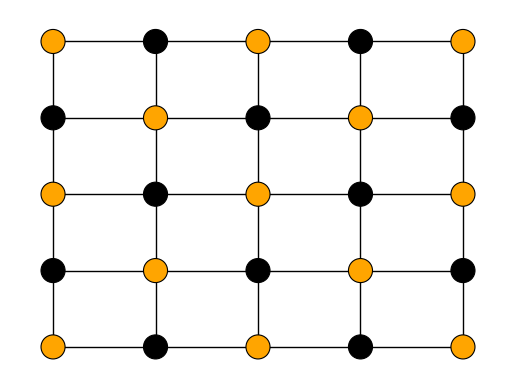

In [31]:
colors, edges, g = generate_grid_graph(5, 5)

all_nodes = colors[1] + colors[2]

node_map = dict(zip(all_nodes, list(range(len(all_nodes)))))

fig, axs = plt.subplots()

plot_grid_graph(g, colors[0], axs)

The blue and orange nodes are the two color groups for our grid graph. Any nodes that are the same color will be sampled simultaneously during block sampling.

With the graph in hand, we can fully define the distribution we want to sample from by choosing a corresponding inverse covariance matrix and mean vector,

In [32]:
# Fixed RNG seed for reproducibility
seed = 4242
key = jax.random.key(seed)

# diagonal elements of the inverse covariance matrix
key, subkey = jax.random.split(key, 2)
cov_inv_diag = jax.random.uniform(subkey, (len(all_nodes),), minval=1, maxval=2)

# add an off-diagonal element to the inverse covariance matrix for each edge in the graph
key, subkey = jax.random.split(key, 2)
# make sure the covaraince matrix is PSD
cov_inv_off_diag = jax.random.uniform(subkey, (len(edges[0]),), minval=-0.25, maxval=0.25)


def construct_inv_cov(diag: Array, all_edges: tuple[list[ContinuousNode], list[ContinuousNode]], off_diag: Array):
    inv_cov = np.diag(diag)

    for n1, n2, cov in zip(*all_edges, off_diag):
        inv_cov[node_map[n1], node_map[n2]] = cov
        inv_cov[node_map[n2], node_map[n1]] = cov

    return inv_cov


# construct a matrix representation of the inverse covariance matrix for convenience
inv_cov_mat = construct_inv_cov(cov_inv_diag, edges, cov_inv_off_diag)

inv_cov_mat_jax = jnp.array(inv_cov_mat)

# mean vector
key, subkey = jax.random.split(key, 2)
mean_vec = jax.random.normal(subkey, (len(all_nodes),))

# bias vector
b_vec = -1 * jnp.einsum("ij, i -> j", inv_cov_mat, mean_vec)

Now we can construct a program to sample from the distribution we just defined. All block sampling routines follow more or less the same set of steps

1. Divide your graph into two sets of blocks. The first set, the "free" blocks, will be updated during sampling. The second set, the "clamped" blocks, will have their nodes fixed to a constant value during sampling. This is often useful. For example, in the case of EBM sampling, this clamping allows for sampling from a distribution conditioned on the clamped nodes.
2. Iteratively update the states of your free blocks. This means:
    1. Initialize the state of each of the free nodes 
    2. Update the state of each of the free nodes according to some rule. The update rule for each node is some function that takes in a set of parameters and the states of some subset of the other nodes in the graph, and returns an updated state for the node.
    3. Make some observation of the current state of the program. This might mean simply writing down the state of some subset of the nodes, or it might mean computing some more complex observable.
    4. Repeat steps 2 and 3 until a statisfactory number of observations have been made

THRML lets you run any version of this procedure that you want while writing minimal amounts of new code. We have to define 3 main things to accomplish this:


1. A block specification: a division of our problem graph into free and clamped blocks
2. A set of interactions: these allow us to specify what information is required to compute the conditional updates for each node in our graph.
3. Conditional sampling rules: these specify how to update the state of each node in our graph given the interactions that are applicable to that node


First, we will define a block spec for our problem. In our case, we simply want to sample each color group in sequence, and we won't be clamping any of the nodes,

In [33]:
# a Block is just a list of nodes that are all the same type
# forcing the nodes in a Block to be of the same type is important for parallelization
free_blocks = [Block(colors[1]), Block(colors[2])]

# we won't be clamping anything here, but in principle this could be a list of Blocks just like above
clamped_blocks = []

# every node in the program has to be assigned a shape and datatype (or PyTree thereof).
# this is so THRML can build an internal "global" representation of the state of the sampling program using a small number of jax arrays
node_shape_dtypes = {ContinuousNode: jax.ShapeDtypeStruct((), jnp.float32)}

# our block specification
spec = BlockGibbsSpec(free_blocks, clamped_blocks, node_shape_dtypes)

Now the interactions. Our PGM is of the undirected variety, which means that it can be described naturally using the language of [Factor Graphs](https://en.wikipedia.org/wiki/Factor_graph). Deep knowledge of factor graphs and their nomenclature isn't necessary to use THRML; in this context, a Factor is simply an interaction between a set of variables that has no natural direction. 

Factor graphs can be viewed as hypergraphs where each factor represents a hyperedge connecting multiple variables. Hyperedges in factor graphs can connect any number of variables, allowing for natural representation of higher-order interactions. For example, a three-way interaction term like $x_1 x_2 x_3$ in an energy function corresponds to a single hyperedge (factor) connecting three variable nodes. 

A nice thing about the Factor formalism is that in the context of Gibbs sampling, the conditional update rule for the $i^{th}$ node depends only on factors that involve $x_i$. This means that given a set of factors for a graph, if we want to update the state of a given node, we only need to consider a small subset of all of the factors that are local to that node. 

In our case, our energy function can we written as a sum of a bunch of terms, each of which is associated with a factor. There are three distinct types of term in this sum, each of which is associated with a different type of factor:

1. $A_{ii} \: x_i^2$
2. $b_i \: x_i$
3. $A_{ij} \: x_i \: x_j$

Each of these factors contributes to our conditional update rule in a different and consistent way. As such, in the context of algorithms like Gibbs sampling, Factors are defined by their ability to produce a set of directed interactions that effect the different nodes they involve in potentially different ways. In the case of our Gaussian sampling problem, our factors generate interactions that are either:

1. Linear: contribute terms to the energy function like $c_i \: x_i$, where $c_i$ does not depend on the "head node" $x_i$ but may depend on some "tail nodes" $x_{nb(i)}$
2. Quadratic: contribute terms to the energy function like $d_i \: x_i^2$, where in our case $d_i$ is a constant independent of the state of the sampling program

THRML implements these abstractions directly in code. 

The most primitive object is the `InteractionGroup`, which specifies what parametric and state information should be supplied to a given node to compute it's conditional update. An `InteractionGroup` is composed of a set of interaction parameters, a set of "head nodes", and sets of "tail nodes". The head nodes are the nodes whose conditional update is effected by the interaction, and the tail nodes specify which neighbouring node states are required to compute the conditional update.


THRML also defines Factors via the `AbstractFactor` interface. In full generality, THRML defines a factor as anything that can be reduced to a set of `InteractionGroup`s. THRML also defines more specialized factors (like ones that define an energy), however we won't be using those here.

We can use these objects to set up our sampling program,

In [34]:
# these are just arrays that we can identify by type, will be useful later


class LinearInteraction(eqx.Module):
    """An interaction of the form $c_i x_i$."""

    weights: Array


class QuadraticInteraction(eqx.Module):
    """An interaction of the form $d_i x_i^2$."""

    inverse_weights: Array


# now we can set up our three different types of factors


class QuadraticFactor(AbstractFactor):
    r"""A factor of the form $w \: x^2$"""

    # 1/A_{ii}
    inverse_weights: Array

    def __init__(self, inverse_weights: Array, block: Block):
        # in general, a factor is initialized via a list of blocks
        # these blocks should all have the same number of nodes, and represent groupings of nodes involved in the factor
        # for example, if a Factor involved 3 nodes, we would initialize it with 3 parallel blocks of equal length
        super().__init__([block])

        # this array has shape [n], where n is the number of nodes in block
        self.inverse_weights = inverse_weights

    def to_interaction_groups(self) -> list[InteractionGroup]:
        # based on our conditional update rule, we can see that we need this to generate a Quadratic interaction with no tail nodes (i.e this interaction has no dependence on the neighbours of x_i)

        # we create an InteractionGroup that implements this interaction

        interaction = InteractionGroup(
            interaction=QuadraticInteraction(self.inverse_weights),
            head_nodes=self.node_groups[0],
            # no tail nodes in this case
            tail_nodes=[],
        )

        return [interaction]


class LinearFactor(AbstractFactor):
    r"""A factor of the form $w \: x$"""

    # b_i
    weights: Array

    def __init__(self, weights: Array, block: Block):
        super().__init__([block])
        self.weights = weights

    def to_interaction_groups(self) -> list[InteractionGroup]:
        # follows the same pattern as previous, still no tail nodes

        return [
            InteractionGroup(interaction=LinearInteraction(self.weights), head_nodes=self.node_groups[0], tail_nodes=[])
        ]


class CouplingFactor(AbstractFactor):
    # A_{ij}
    weights: Array

    def __init__(self, weights: Array, blocks: tuple[Block, Block]):
        # in this case our factor involves two nodes, so it is initialized with two blocks
        super().__init__(list(blocks))
        self.weights = weights

    def to_interaction_groups(self) -> list[InteractionGroup]:
        # this factor produces interactions that impact both sets of nodes that it touches
        # i.e if this factor involves a term like w x_1 x_2, it should produce one interaction with weight w that has x_1 as a head node and x_2 as a tail node,
        # and another interaction with weight w that has x_2 as a head node and x_1 as a tail node

        # if we were sure that x_1 and x_2 were always the same type of node, the two interactions could be part of the same InteractionGroup
        # we won't worry about that here though
        return [
            InteractionGroup(LinearInteraction(self.weights), self.node_groups[0], [self.node_groups[1]]),
            InteractionGroup(LinearInteraction(self.weights), self.node_groups[1], [self.node_groups[0]]),
        ]

Now the conditional update the rule. Here, we will define how the relevant interaction and state information should be used to produce an updated state in our iterative sampling algorithm.

In [35]:
class GaussianSampler(AbstractConditionalSampler):
    def sample(
        self,
        key: Key,
        interactions: list[PyTree],
        active_flags: list[Array],
        states: list[list[_State]],
        sampler_state: _SamplerState,
        output_sd: PyTree[jax.ShapeDtypeStruct],
    ) -> tuple[Array, _SamplerState]:
        # this is where the rubber meets the road in THRML

        # this function gets called during block sampling, and must take in information about interactions and neighbour states and produce a state update

        # interactions, active_flags, and states are three parallel lists.

        # each item in interactions is a pytree, for which each array will have shape [n, k, ...].
        # this is generated by THRML from the set of InteractionGroups that are used to create a sampling program
        # n is the number of nodes that we are updating in parallel during this call to sample
        # k is the maximum number of times any node in the block that is being updated shows up as a head node for this interaction

        # each item in active_flags is a boolean array with shape [n, k].
        # this is padding that is generated internally by THRML based on the graphical structure of the model,
        # and serves to allow for heterogeneous graph sampling to be vectorized on accelerators that rely on homogeneous data structures

        # each item in states is a list of Pytrees that represents the state of the tail nodes that are relevant to this interaction.
        # for example, for an interaction with a single tail node that has a scalar dtype, states would be:
        # [[n, k],]

        bias = jnp.zeros(shape=output_sd.shape, dtype=output_sd.dtype)
        var = jnp.zeros(shape=output_sd.shape, dtype=output_sd.dtype)

        # loop through all of the available interactions and process them appropriately

        # here we are simply implementing the math of our conditional update rule

        for active, interaction, state in zip(active_flags, interactions, states):
            if isinstance(interaction, LinearInteraction):
                # if there are tail nodes, contribute w * x_1 * x_2 * ..., otherwise contribute w
                state_prod = jnp.array(1.0)
                if len(state) > 0:
                    state_prod = jnp.prod(jnp.stack(state, -1), -1)
                bias -= jnp.sum(interaction.weights * active * state_prod, axis=-1)

            if isinstance(interaction, QuadraticInteraction):
                # this just sets the variance of the output distribution
                # there should never be any tail nodes

                var = active * interaction.inverse_weights
                var = var[..., 0]  # there should only ever be one

        return (jnp.sqrt(var) * jax.random.normal(key, output_sd.shape)) + (bias * var), sampler_state

    def init(self) -> _SamplerState:
        return None

With all of the parts fully defined, we can now construct our sampling program

In [36]:
# our three types of factor
lin_fac = LinearFactor(b_vec, Block(all_nodes))
quad_fac = QuadraticFactor(1 / cov_inv_diag, Block(all_nodes))
pair_quad_fac = CouplingFactor(cov_inv_off_diag, (Block(edges[0]), Block(edges[1])))

# an instance of our conditional sampler
sampler = GaussianSampler()

# the sampling program itself. Combines the three main components we just built
prog = FactorSamplingProgram(
    gibbs_spec=spec,
    # one sampler for every free block in gibbs_spec
    samplers=[sampler, sampler],
    factors=[lin_fac, quad_fac, pair_quad_fac],
    other_interaction_groups=[],
)

`FactorSamplingProgram` is a thin wrapper on the more generic `BlockSamplingProgram`. All `FactorSamplingProgram` does is convert all of the factors passed in into `InteractionGroups` and then use them to create a `BlockSamplingProgram'. As such, prog is equivalent to prog_2 in the following:

In [37]:
groups = []
for fac in [lin_fac, quad_fac, pair_quad_fac]:
    groups += fac.to_interaction_groups()

prog_2 = BlockSamplingProgram(gibbs_spec=spec, samplers=[sampler, sampler], interaction_groups=groups)

Now we are finally ready to do some sampling! A sampling program in THRML simply repeatedly updates the state of each free block in the order they appear in the gibbs_spec. After every iteration of the sampling algorithm, we may observe the state and write down some information that is relevant to the problem we are trying to solve. For example, if we wanted to extract samples from some subset of the nodes of our PGM, after each iteration we could simply memorize some subset of the current state. This functionality is provided by observers in THRML.

For the purposes of this example, it would be prudent to check that our sampling program is working correctly. To do this, we will compute estimators of some first and second moments and verify that they match up with expected values from the theory. We will use the built-in `MomentAccumulatorObserver` to accomplish this.

In [38]:
# we will estimate the covariances for each pair of nodes connected by an edge and compare against theory
# to do this we will need to estimate first moments and second moments
second_moments = [(e1, e2) for e1, e2 in zip(*edges)]
first_moments = [[(x,) for x in y] for y in edges]

# this will accumulate products of the node state specified by first_moments and second_moments
observer = MomentAccumulatorObserver(first_moments + [second_moments])

Now all that is left to do is specify a few more details about how the sampling should proceed. 

In [39]:
# how many parallel sampling chains will we run?
n_batches = 1000


schedule = SamplingSchedule(
    # how many iterations to do before drawing the first sample
    n_warmup=0,
    # how many samples to draw in total
    n_samples=10000,
    # how many steps to take between samples
    steps_per_sample=5,
)

# construct the initial state of the iterative sampling algorithm
init_state = []
for block in spec.free_blocks:
    key, subkey = jax.random.split(key, 2)
    init_state.append(
        0.1
        * jax.random.normal(
            subkey,
            (
                n_batches,
                len(block.nodes),
            ),
        )
    )

# RNG keys to use for each chain in the batch
keys = jax.random.split(key, n_batches)

# memory to hold our moment values
init_mem = observer.init()

Now run the sampling:

In [40]:
# we use vmap to run a bunch of parallel sampling chains
moments, _ = jax.vmap(lambda k, s: sample_with_observation(k, prog, schedule, s, [], init_mem, observer))(
    keys, init_state
)

# Take a mean over the batch axis and divide by the total number of samples
moments = jax.tree.map(lambda x: jnp.mean(x, axis=0) / schedule.n_samples, moments)

# compute the covariance values from the moment data
covariances = moments[-1] - (moments[0] * moments[1])

We can compare our covariance estimates to the real covariance matrix to see if we implemented our sampling routine correctly

In [41]:
cov = np.linalg.inv(inv_cov_mat)

node_map = dict(zip(all_nodes, list(range(len(all_nodes)))))

real_covs = []

for edge in zip(*edges):
    real_covs.append(cov[node_map[edge[0]], node_map[edge[1]]])

real_covs = np.array(real_covs)

error = np.max(np.abs(real_covs - covariances)) / np.abs(np.max(real_covs))

print(error)
assert error < 0.01

0.0045360937


We achieve a really small error because we computed a ton of samples. If you reduce either the batch size or the number of samples collected by each chain this number will go up.

That is everything you need to know to implement any type of PGM block sampling routine you want in THRML. 

However, you don't always have to do everything completely from scratch! THRML exposes a limited set of higher-level functionality fine-tuned to sampling problems that Extropic really cares about. 


Next, we will use some of these higher-level functions to implement a more complicated type of model that can't be sampled from using analytical techniques. In particular, we will implement sampling from a deep Gaussian-Bernoulli EBM. This  type of model has the energy function

$$ E(x) = E_G(x) + E_{GB}(x, s) + E_B(s)$$

where $x$ is a vector of continuous values and $s$ is a vector of *spins*, $s_i \in \{-1, 1\}$.

$E_G(x)$ is the Gaussian energy function defined in the previous section. $E_{GB}$ is an energy function that represents the interaction between the continuous and spin-valued variables,

$$ E_{GB}(x, s) = \sum_{ (i, j) \in S_{GB}} W_{ij} \: y_i \: x_j $$

where $S_{GB}$ is a set of edges connecting spin and continuous variables.

$E_{B}$ is the spin energy function,

$$ E_B(s) = \sum_i b_i s_i + \sum_{j > i} J_{ij} s_i s_j $$


Just for fun, lets use a more complicated graph topology for this problem. We will stick with a grid, but we will add skip-connections that allow for non-nearest-neighbour interactions. We can once again use NetworkX to make this graph,

In [42]:
# first, define a new type of node


class SpinNode(AbstractNode):
    pass

In [43]:
# now, build a random grid out of spin and continuous nodes


def make_random_typed_grid(
    rows: int,
    cols: int,
    seed: int,
    p_cont: float = 0.5,
):
    rng = random.Random(seed)

    # every time we make a node, flip a coin to decide what type it should be
    grid = [[ContinuousNode() if rng.random() < p_cont else SpinNode() for _ in range(cols)] for _ in range(rows)]

    # Parity-based 2-coloring
    bicol = {grid[r][c]: ((r + c) & 1) for r in range(rows) for c in range(cols)}

    # Separate by color and type
    colors_by_type = {
        0: {SpinNode: [], ContinuousNode: []},
        1: {SpinNode: [], ContinuousNode: []},
    }
    for r in range(rows):
        for c in range(cols):
            n = grid[r][c]
            color = bicol[n]
            colors_by_type[color][type(n)].append(n)

    return grid, colors_by_type


grid, coloring = make_random_typed_grid(30, 30, seed)

In [44]:
# now generate the edges to implement our desired skip-connected grid
# we will use only odd-length edges (1, 3, 5, ...) so that our 2-coloring remains valid
def build_skip_graph_from_grid(
    grid: list[list[AbstractNode]],
    skips: list[int],
):
    rows, cols = len(grid), len(grid[0])

    # Build graph & annotate nodes with coords and type
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            n = grid[r][c]
            G.add_node(n, coords=(r, c))

    # Edges sorted by edge length
    u_all = []
    v_all = []
    for k in skips:
        # vertical: (r, c) -> (r+k, c)
        for r in range(rows - k):
            r2 = r + k
            for c in range(cols):
                n1 = grid[r][c]
                n2 = grid[r2][c]
                u_all.append(n1)
                v_all.append(n2)
                G.add_edge(n1, n2)

        # horizontal: (r, c) -> (r, c+k)
        for r in range(rows):
            for c in range(cols - k):
                c2 = c + k
                n1 = grid[r][c]
                n2 = grid[r][c2]
                u_all.append(n1)
                v_all.append(n2)
                G.add_edge(n1, n2, skip=k)

    return (u_all, v_all), G


edge_lengths = [1, 3, 5]
edges, graph = build_skip_graph_from_grid(grid, edge_lengths)

Let's visualize this graph to understand what we just created. Since the graph is no longer planar, it will be cleanest to plot the local neighbourhood of particular nodes in our grid one at a time.

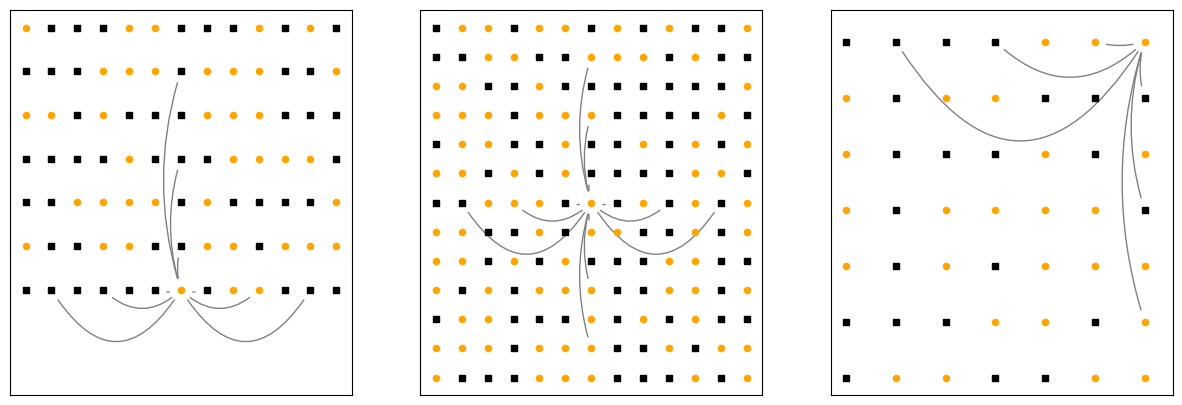

In [45]:
def plot_node_neighbourhood(
    grid,
    G: nx.Graph,
    center: Hashable,
    hops: int,
    ax: plt.Axes,
) -> None:
    rows, cols = len(grid), len(grid[0])
    r, c = G.nodes[center]["coords"]

    # make a rectangular subgrid
    r0, r1 = max(0, r - hops), min(rows - 1, r + hops)
    c0, c1 = max(0, c - hops), min(cols - 1, c + hops)
    rect_nodes = {grid[i][j] for i in range(r0, r1 + 1) for j in range(c0, c1 + 1)}

    # collect the relevant edges by length
    edges_by_k = defaultdict(list)
    for v, ed in G[center].items():
        k = int(ed.get("skip", 1))
        edges_by_k[k].append((center, v))

    # draw edges as arcs
    max_k = max(edges_by_k.keys(), default=1)
    curve_scale = 0.8
    edge_width = 1.0
    alpha = 1.0

    def rad_for_edge(u, v, k):
        r1, c1 = G.nodes[u]["coords"]
        r2, c2 = G.nodes[v]["coords"]
        base = curve_scale * (k / max_k)
        # choose bend direction based on quadrant:
        if c1 == c2:
            sign = +1.0 if r2 < r1 else -1.0  # up vs down
        else:  # horizontal edge
            sign = +1.0 if c2 > c1 else -1.0  # right vs left
        return sign * base

    # positions for plotting
    pos = {n: (G.nodes[n]["coords"][1], G.nodes[n]["coords"][0]) for n in rect_nodes | {center}}

    for i, k in enumerate(sorted(edges_by_k)):
        for u, v in edges_by_k[k]:
            nx.draw_networkx_edges(
                G,
                pos,
                edgelist=[(u, v)],
                ax=ax,
                edge_color="gray",
                width=edge_width,
                alpha=alpha,
                arrows=True,
                arrowstyle="-",
                connectionstyle=f"arc3,rad={rad_for_edge(u, v, k)}",
            )

    # draw nodes
    cont_nodes = [n for n in rect_nodes if n.__class__ == ContinuousNode]
    spin_nodes = [n for n in rect_nodes if n.__class__ == SpinNode]

    node_size = 20.0

    nx.draw_networkx_nodes(G, pos, nodelist=cont_nodes, node_color="black", node_shape="s", node_size=node_size, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=spin_nodes, node_color="orange", node_shape="o", node_size=node_size, ax=ax)


# pick a few nodes in the grid to inspect
centers = [grid[0][7], grid[10][10], grid[-1][-1]]

fig, axs = plt.subplots(nrows=1, ncols=len(centers), figsize=(len(centers) * 5, 5))


for ax, center in zip(axs, centers):
    plot_node_neighbourhood(grid, graph, center, max(edge_lengths) + 1, ax)

This problem is clearly much more heterogeneous than what we were looking at before. Every node has a unique local neighbourhood, and is connected to a potentially different number of spin and continuous nodes. This makes working with this graph on an accelerator like a GPU tricky. As we will now see, THRML was specifically designed to handle this heterogeneity.

With our graph in hand, let's set up our sampling program. We can re-use a lot of the work that we did in the simpler example. First, let's sort the nodes and edges by type. 

In [20]:
# collect the different types of nodes
spin_nodes = []
cont_nodes = []
for node in graph.nodes:
    if isinstance(node, SpinNode):
        spin_nodes.append(node)
    else:
        cont_nodes.append(node)


# spin-spin interactions
ss_edges = [[], []]

# continuous-continuous interactions
cc_edges = [[], []]

# spin-continuous interactions
sc_edges = [[], []]

for edge in zip(*edges):
    if isinstance(edge[0], SpinNode) and isinstance(edge[1], SpinNode):
        ss_edges[0].append(edge[0])
        ss_edges[1].append(edge[1])
    elif isinstance(edge[0], ContinuousNode) and isinstance(edge[1], ContinuousNode):
        cc_edges[0].append(edge[0])
        cc_edges[1].append(edge[1])
    elif isinstance(edge[0], SpinNode):
        sc_edges[0].append(edge[0])
        sc_edges[1].append(edge[1])
    else:
        sc_edges[1].append(edge[0])
        sc_edges[0].append(edge[1])

Now we can set up some interactions. For some of the factors, we will re-use our code from the first part of this example 

In [21]:
# we will just randomize the weights

key, subkey = jax.random.split(key, 2)
cont_quad = QuadraticFactor(jax.random.uniform(subkey, (len(cont_nodes),), minval=2, maxval=3), Block(cont_nodes))

key, subkey = jax.random.split(key, 2)
cont_linear = LinearFactor(jax.random.normal(subkey, (len(cont_nodes),)), Block(cont_nodes))

key, subkey = jax.random.split(key, 2)
cont_coupling = CouplingFactor(
    jax.random.uniform(subkey, (len(cc_edges[0]),), minval=-1 / 10, maxval=1 / 10),
    (Block(cc_edges[0]), Block(cc_edges[1])),
)

key, subkey = jax.random.split(key, 2)
spin_con_coupling = CouplingFactor(
    jax.random.normal(subkey, (len(sc_edges[0]),)), (Block(sc_edges[0]), Block(sc_edges[1]))
)

For the factors that involve only spin variables, we will use some built in functionality from THRML. THRML implements sampling functionality for arbitrary discrete-variable EBMs in `thrml.models.discrete_ebm` that we can apply to our problem. First, the spin factors,

In [22]:
key, subkey = jax.random.split(key, 2)
spin_linear = SpinEBMFactor([Block(spin_nodes)], jax.random.normal(subkey, (len(spin_nodes),)))

key, subkey = jax.random.split(key, 2)
spin_coupling = SpinEBMFactor([Block(x) for x in ss_edges], jax.random.normal(subkey, (len(ss_edges[0]),)))

The Gaussian sampler we wrote for the first part will work our new problem as it is because it won't be seeing any new types of interactions. The Binary sampler built into THRML will have to be extended to handle our `LinearInteraction`. Luckily, it was designed with this kind of modification in mind.

In [23]:
class ExtendedSpinGibbsSampler(SpinGibbsConditional):
    def compute_parameters(
        self,
        key: Key,
        interactions: list[PyTree],
        active_flags: list[Array],
        states: list[list[_State]],
        sampler_state: _SamplerState,
        output_sd: PyTree[jax.ShapeDtypeStruct],
    ) -> PyTree:
        field = jnp.zeros(output_sd.shape, dtype=float)

        unprocessed_interactions = []
        unprocessed_active = []
        unprocessed_states = []

        for interaction, active, state in zip(interactions, active_flags, states):
            # if its our new interaction, handle it
            if isinstance(interaction, LinearInteraction):
                state_prod = jnp.prod(jnp.stack(state, -1), -1)
                field -= jnp.sum(interaction.weights * active * state_prod, axis=-1)

            # if we haven't seen it, remember it
            else:
                unprocessed_interactions.append(interaction)
                unprocessed_active.append(active)
                unprocessed_states.append(state)

        # make the parent class deal with THRML-native interactions
        field -= super().compute_parameters(
            key, unprocessed_interactions, unprocessed_active, unprocessed_states, sampler_state, output_sd
        )[0]

        return field, sampler_state

This is all the work we need to do to sample from our new graph using THRML! All that is left is to set up our Block spec and run some sampling.

In [24]:
# tell THRML the shape and datatype of our new node
new_sd = {SpinNode: jax.ShapeDtypeStruct(shape=(), dtype=jnp.bool)}

# Our new graph is still two-colorable, however within each color there are two different types of node
# this means that we can't make a single block to represent each color because all of the nodes within a block have to be of the same type
# however, we might still want to ensure that the two blocks that represent each color group are sampled at the same "algorithmic" time
# i.e even though we can't sample these blocks directly in parallel because they use different update rules, we want to make sure that they
# receive the same state information
# we can make this happen in THRML by passing in a list of tuples of blocks to BlockGibbsSpec instead of a list of Blocks
# the blocks in each tuple will be sampled at the same algorithmic time
blocks = [
    (Block(coloring[0][SpinNode]), Block(coloring[0][ContinuousNode])),
    (Block(coloring[1][SpinNode]), Block(coloring[1][ContinuousNode])),
]

block_spec = BlockGibbsSpec(blocks, [], node_shape_dtypes | new_sd)

# now we can assemble our program

# first, choose the right update rule for each block in the spec
ber_sampler = ExtendedSpinGibbsSampler()
samplers = []
for block in block_spec.free_blocks:
    if isinstance(block.nodes[0], SpinNode):
        samplers.append(ber_sampler)
    else:
        samplers.append(sampler)

# collect all of our factors
factors = [cont_quad, cont_linear, cont_coupling, spin_con_coupling, spin_linear, spin_coupling]

program = FactorSamplingProgram(block_spec, samplers, factors, [])

Our program is doing a lot of work to pad out the interaction structure and make our sampling program GPU-compatible:

In [25]:
# let's look at an example of the padding
program.per_block_interaction_active[0][0][0]

Array([ True,  True,  True,  True,  True, False, False, False, False,
       False], dtype=bool)

Now we are ready to sample. In this case, we will simply observe the state of our nodes directly

In [26]:
batch_size = 50

schedule = SamplingSchedule(
    # how many iterations to do before drawing the first sample
    n_warmup=100,
    # how many samples to draw in total
    n_samples=300,
    # how many steps to take between samples
    steps_per_sample=15,
)


# construct the initial state of the iterative sampling algorithm
init_state = []
for block in block_spec.free_blocks:
    init_shape = (
        batch_size,
        len(block.nodes),
    )
    key, subkey = jax.random.split(key, 2)
    if isinstance(block.nodes[0], ContinuousNode):
        init_state.append(0.1 * jax.random.normal(subkey, init_shape))
    else:
        init_state.append(jax.random.bernoulli(subkey, 0.5, init_shape))

key, subkey = jax.random.split(key, 2)
keys = jax.random.split(subkey, batch_size)

samples = jax.vmap(lambda k, i: sample_states(k, program, schedule, i, [], [Block(spin_nodes), Block(cont_nodes)]))(
    keys, init_state
)

Let's visualize our samples. Our data is very high-dimensional, but we can use a PCA to try and get some idea of the structure of the distribution.

In [27]:
all_samples = jnp.concatenate(samples, axis=-1)
pca = PCA(n_components=3)
preproc_data = StandardScaler().fit_transform(jnp.reshape(all_samples, (-1, all_samples.shape[-1])))
transformed_data = pca.fit_transform(preproc_data)

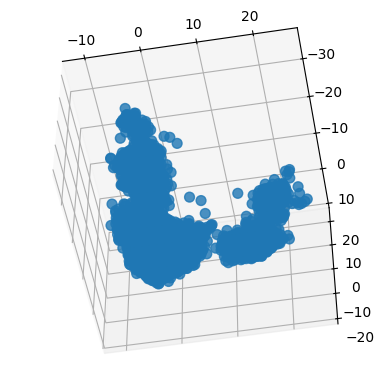

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    transformed_data[:, 0],  # PC1
    transformed_data[:, 1],  # PC2
    transformed_data[:, 2],  # PC3
    s=50,
    alpha=0.8,
)
ax.view_init(elev=-50, azim=280)
plt.show()

This distribution is clearly non-Gaussian and complex, despite the random initialization.

If you've made it to the end of this example and have been paying attention you are now ready to use THRML for your own research-grade problems! We are very excited to see what you make with it.